In [14]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import cm
import zipfile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Descomprimir el archivo ZIP
ruta_comprimida = '/content/ChestXRay2017.zip'

with zipfile.ZipFile(ruta_comprimida, 'r') as zip_ref:
  zip_ref.extractall('/content')

print(f"Archivos descomprimidos en el directorio: /content")

Archivos descomprimidos en el directorio: /content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# Load and preprocess data
def preprocess_data(img_size=200):
    def upload_images(directory):
        data = []
        for label in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                if file.endswith('.jpeg'):
                    img_path = os.path.join(path, file)
                    img = Image.open(img_path).convert('L')  # Grayscale
                    img = img.resize((img_size, img_size))
                    mask = np.zeros((img_size, img_size, 1)) if label == 'NORMAL' else np.ones((img_size, img_size, 1))
                    data.append((np.array(img), mask))
        return data

    train = upload_images('/content/ChestXRay2017/train')
    test = upload_images('/content/ChestXRay2017/test')
    val = upload_images('/content/ChestXRay2017/val')

    # Shuffle and split into arrays
    def prepare_data(data):
        random.shuffle(data)
        images = np.array([item[0] for item in data]).reshape(-1, img_size, img_size, 1) / 255.0
        masks = np.array([item[1] for item in data])
        return images, masks

    X_train, y_train = prepare_data(train)
    X_test, y_test = prepare_data(test)
    X_val, y_val = prepare_data(val)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data()

In [5]:
# U-Net model definition
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.25)(p1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.25)(p2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.25)(p3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.Concatenate()([u1, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.Concatenate()([u2, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.Concatenate()([u3, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

In [19]:
# Train U-Net model
def train_unet(X_train, y_train, X_val, y_val, input_shape, epochs=15, batch_size=10):
    model = unet_model(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Configurar el EarlyStopping para detener el entrenamiento si 'val_loss' no mejora después de 10 épocas
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Configurar el ModelCheckpoint para guardar el mejor modelo basado en 'val_loss'
    model_checkpoint = ModelCheckpoint(
        filepath='best_model.keras',
        save_best_only=True,
        monitor='val_loss'
    )


    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks = [early_stopping, model_checkpoint]
    )

    return model, history

In [20]:
input_shape = (200, 200, 1)
model, history = train_unet(X_train, y_train, X_val, y_val, input_shape)

Epoch 1/15
524/524 ━━━━━━━━━━━━━━━━━━━━ 193s 339ms/step - accuracy: 0.7665 - loss: 0.4877 - val_accuracy: 0.5000 - val_loss: 3.7872
Epoch 2/15
524/524 ━━━━━━━━━━━━━━━━━━━━ 183s 321ms/step - accuracy: 0.8680 - loss: 0.3049 - val_accuracy: 0.5154 - val_loss: 1.1797
Epoch 3/15
524/524 ━━━━━━━━━━━━━━━━━━━━ 168s 320ms/step - accuracy: 0.8931 - loss: 0.2584 - val_accuracy: 0.6824 - val_loss: 0.6034
Epoch 4/15
524/524 ━━━━━━━━━━━━━━━━━━━━ 202s 319ms/step - accuracy: 0.9105 - loss: 0.2248 - val_accuracy: 0.6121 - val_loss: 0.7718
Epoch 5/15
524/524 ━━━━━━━━━━━━━━━━━━━━ 203s 321ms/step - accuracy: 0.9244 - loss: 0.1970 - val_accuracy: 0.7023 - val_loss: 0.5885
Epoch 6/15
524/524 ━━━━━━━━━━━━━━━━━━━━ 201s 318ms/step - accuracy: 0.9403 - loss: 0.1594 - val_accuracy: 0.6877 - val_loss: 0.6512
Epoch 7/15
524/524 ━━━━━━━━━━━━━━━━━━━━ 202s 318ms/step - accuracy: 0.9466 - loss: 0.1425 - val_accuracy: 0.5606 - val_loss: 1.6398
Epoch 8/15
524/524 ━━━━━━━━━━━━━━━━━━━━ 202s 318ms/step - accuracy: 0.9564 -

In [21]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.8063 - loss: 0.4377
Test Accuracy: 80.74%


In [22]:
# Calcular métricas adicionales
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Aplanar las matrices para calcular las métricas
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()

accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step
Accuracy: 80.74%
Precision: 79.04%
Recall: 94.15%
F1 Score: 85.93%


In [23]:
def predict_and_visualize(model, image_path, img_size):
    # Preprocesar la imagen
    image = Image.open(image_path).convert('L')
    original_size = image.size
    image = image.resize((img_size, img_size))
    image = np.array(image).reshape(1, img_size, img_size, 1) / 255.0

    # Hacer la predicción
    prediction = model.predict(image)[0].squeeze()

    # Redimensionar la máscara al tamaño original de la imagen
    mask = Image.fromarray((prediction * 255).astype(np.uint8)).resize(original_size, Image.NEAREST)
    mask = np.array(mask) / 255.0  # Normalizar la máscara

    # Aplicar un colormap a la máscara
    heatmap = cm.jet(mask)[:, :, :3]  # Obtener los colores RGB del mapa de calor
    heatmap = (heatmap * 255).astype(np.uint8)  # Convertir a valores enteros

    # Crear la imagen superpuesta
    original_image = np.array(Image.open(image_path).convert('RGB')) / 255.0
    combined_image = original_image * 0.7 + heatmap / 255.0 * 0.3

    # Determinar la etiqueta de clase
    label = 'PNEUMONIA' if np.mean(mask) > 0.5 else 'NORMAL'

    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 0.05]})

    # Imagen original
    axes[0].imshow(Image.open(image_path).convert('RGB'))
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')

    # Imagen original con máscara superpuesta
    im = axes[1].imshow(combined_image)
    axes[1].set_title(f"{label}")
    axes[1].axis('off')

    # Barra de color
    cbar = fig.colorbar(cm.ScalarMappable(cmap='jet'), cax=axes[2])
    cbar.set_label('Probabilidad de Neumonía')
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['Baja', 'Media', 'Alta'])

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


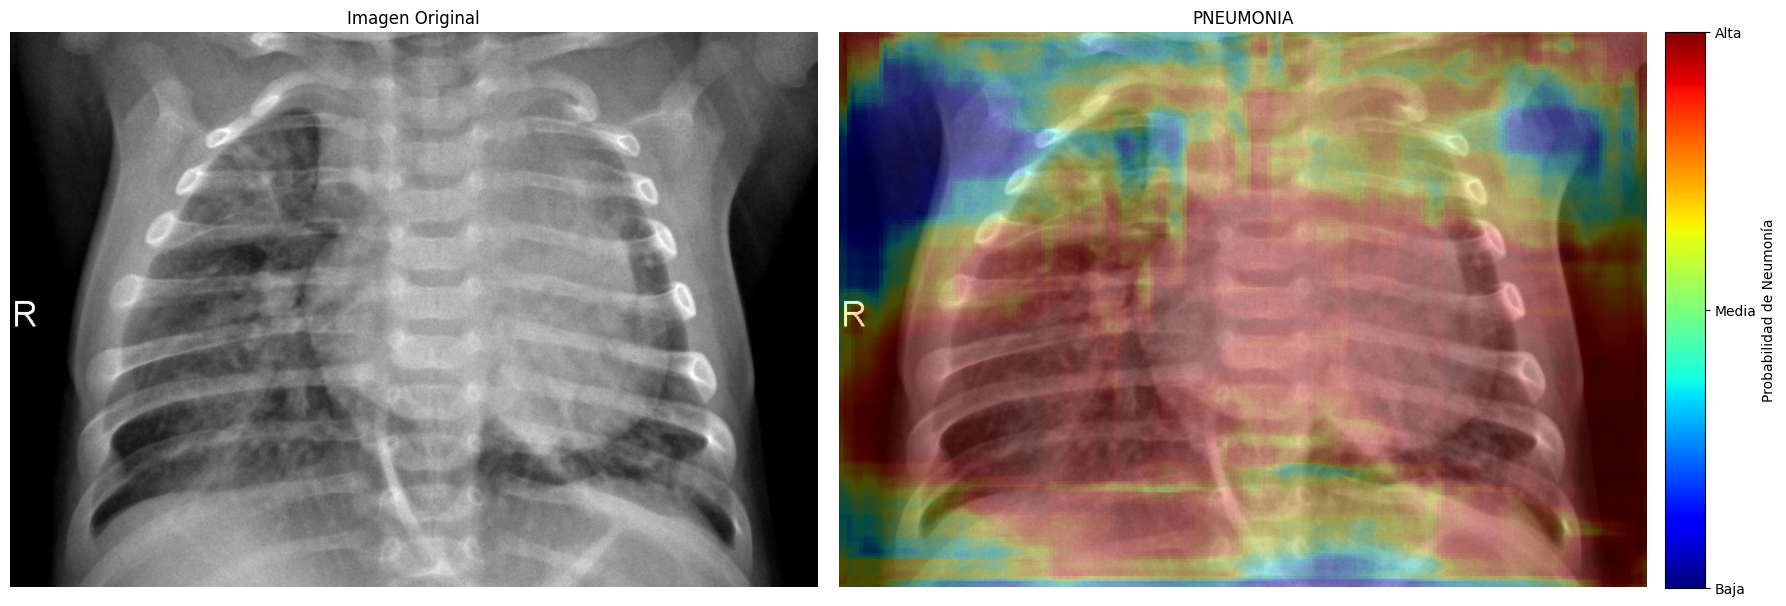

In [24]:
# Ruta a la imagen de ejemplo neumonia
image_path1 = '/content/ChestXRay2017/test/PNEUMONIA/person100_bacteria_475.jpeg'
# Hacer la predicción y visualizar la máscara
predict_and_visualize(model, image_path1, 200)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


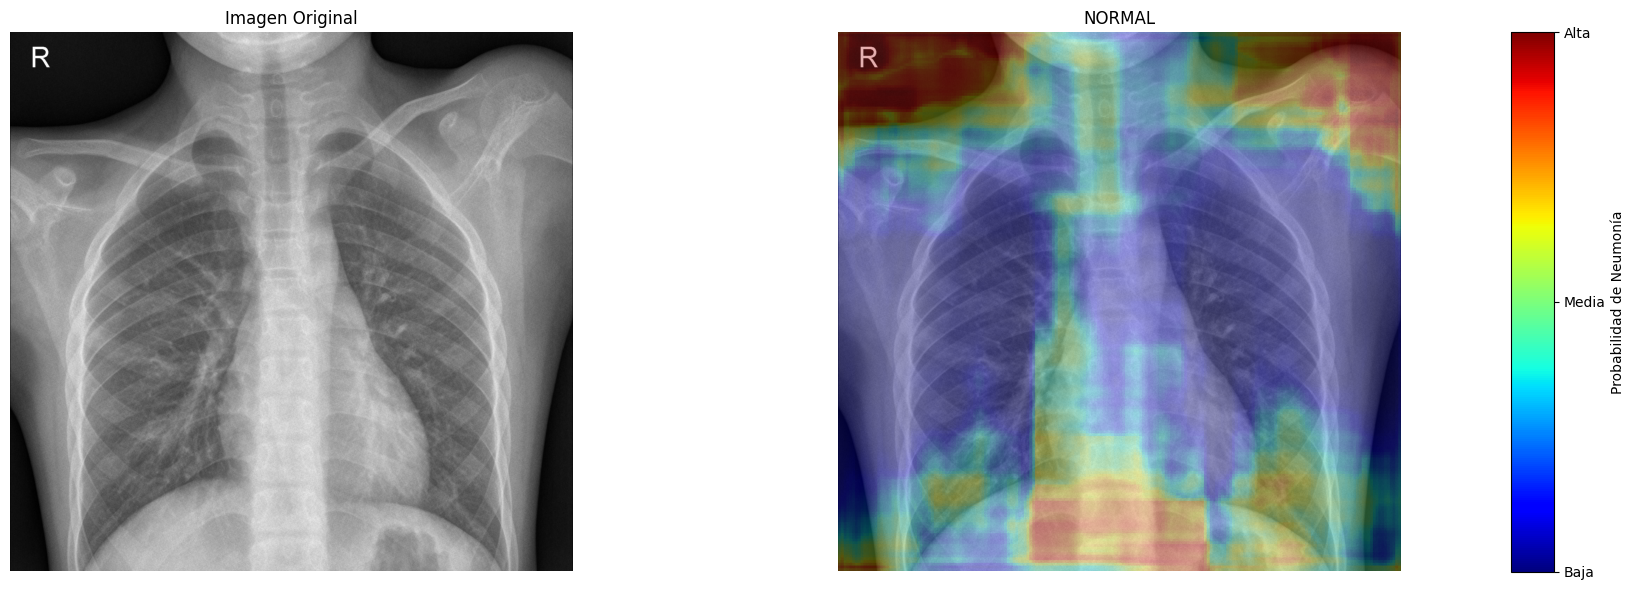

In [25]:
# Ruta a la imagen de ejemplo normal
image_path2 = '/content/ChestXRay2017/test/NORMAL/IM-0011-0001.jpeg'
# Hacer la predicción y visualizar la máscara
predict_and_visualize(model, image_path2, 200)

In [26]:
# Save model
model.save("pneumonia_detection_unet.keras")